# Molecular VAE

In [1]:
# packages
import pandas as pd
import numpy as np
import torch
import torch.utils.data as tud
from torch import nn
from torch.nn import functional as F

# project modules
from utils import SMILESTokenizer, SMILESVocabulary, SMILESDataset, countTokens
from models import MolecularVAE

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# chemistry
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True  #set this to False if you want PNGs instead of SVGs

RDKit WARNING: [18:37:18] Enabling RDKit 2019.09.1 jupyter extensions


## Load data

In [2]:
chembl = pd.read_csv("data/cleaned_dataset.csv")
chembl.head()

,ChEMBL ID,Smiles,AlogP,QED Weighted
0,CHEMBL2333117,CC(C)Nc1c(C(N)=O)nnc2ccc(-c3cnn(C)c3)cc12,1.95,0.77
1,CHEMBL1189585,CC1C(=O)NC2=Nc3sc4c(c3CN21)CCCC4,1.95,0.78
2,CHEMBL4089494,CNC(=O)c1ccc(NC(=O)Nc2ccc(-c3nc(N4CCOCC4)c4ncc...,3.53,0.40
3,CHEMBL1189590,CN(C)c1nccc2c1nnn2Cc1ccccc1F,2.08,0.73
4,CHEMBL3927722,Cc1noc(C)c1Cn1cc(NC(=O)Cc2ccco2)cn1,2.31,0.78


## Data preparation & encoding

Steps to prepare VAE input data:
1. SMILES tokenization (add start/end tokens)
2. SMILES token encoding (convert to integer indecies) -> build a vocabulary
3. Set up a SMILES dataset class (for feeding batches of data to the VAE)

### Build a vocabulary

In [3]:
tokenizer = SMILESTokenizer()
vocabulary = SMILESVocabulary()

In [4]:
# vocabulary.build(chembl["Smiles"], tokenizer)

In [5]:
# # save vocabulary
# vocabulary.save("data/vocabulary.csv")

In [6]:
# load vocabulary
vocabulary.load("data/vocabulary.csv")

### Analyze token frequencies

In [11]:
token_cnts = countTokens(chembl["Smiles"], tokenizer)
token_cnts

,token,cnt
0,C,12896279
1,(,7025189
2,),7025189
3,N,2682981
4,c,18431345
5,1,4604265
6,=,2904352
7,O,4388805
8,n,2124346
9,2,3590237


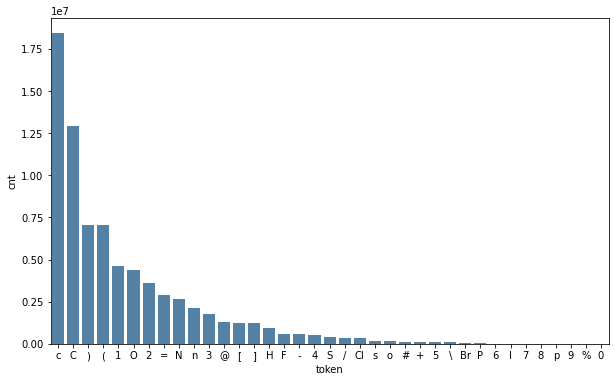

In [12]:
# plot token distribution
fig, ax = plt.subplots(figsize=(10, 6))
_ = sns.barplot(data=token_cnts.sort_values("cnt", ascending=False), x="token", y="cnt", color="steelblue", ax=ax)

## Train/validation/test split

A randomly selected validation (10 %) and test (10 %) set will be put aside for monitoring the network training process itself (validation set) and evaluating the trained models (test set).

Models will be evaluated in terms of the mean negative log-likelihoods (**NLL**) of the test set sequences (SMILES). The lower the better.

$$NLL=-\log{p(S)}=-\frac{1}{m}\sum_{i=1}^{m} \log{p(s_i)}$$

where S is the set of SMILES strings, $p(s_i)$ is the probability of a SMILES string $s_i$ and $m$ is the number of sequences in the set S. The probability of a SMILES string is obtained from the RNN decoder net of the VAE.

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train, test = train_test_split(chembl, test_size=0.1, random_state=42)
train, validation = train_test_split(train, test_size=0.1, random_state=42)

In [13]:
test.shape

(159568, 4)

### Build a dataset

A dataset is created for each split so batches of samples can easily be fed to the model.

In [14]:
train_ds = SMILESDataset(train["Smiles"], vocabulary, tokenizer)
val_ds = SMILESDataset(validation["Smiles"], vocabulary, tokenizer)
test_ds = SMILESDataset(test["Smiles"], vocabulary, tokenizer)

## NN models

The variational autoencoder consists of the following components:
1. SMILES encoder: maps input sequences to a latent vector z.
2. Decoder: decodes a latent vector z into a sequence.

In [15]:
vae = MolecularVAE(len(vocabulary), 8, 64, 128, vocabulary.getStartIdx(), vocabulary.getEndIdx(), 
                   vocabulary.getPadIdx(), rnn_layers=2, bidirectional=True, dropout=0.1)

## Model training

### The loss function

The loss function used for training the VAE is the Evidence Lower Bound (**ELBO**). It consists of 2 terms and represents the lower bound on the marginal log-likelihood of the data:

$$ELBO(S;\theta) = E_{q_{\theta}(Z|S)}[\log{p_{\theta}(S|Z)}] - KL(q_{\theta}(Z|S)||p(Z)) \leq \log{p(S)}$$

Here, $Z$ is the latent vector variable, $S$ is the observed SMILES data (evidence), $q_{\theta}(Z|S)$ is the approximation to the true posterior distribution, $p_{\theta}(S|Z)$ is the conditional distribution over $S$ given $Z$ (decoder output), $p(Z)$ is the prior ditribution of the latent vector $Z$, and $p(S)$ is the marginal distribution of the data.

The first term is estimated using a single sample drawn from the posterior, whereas the KL term is computed analytically in closed form. The goal of the optimization is to maximize the lower bound, and this can be achieved by minimizing its negative:

$$L(S;\theta) = -\log{q_{\theta}(S|Z)} + KL(q_{\theta}(Z|S)||p(Z))$$

Here also the expectation term was replaced by the neg. log-likelihood of $S$ given a single $Z$ drawn from $q_{\theta}(Z|S)$ as explained above. For a minibatch of samples - $S$, the loss function then becomes:

$$L(S;\theta) = -\frac{1}{m}\sum_{i=1}^{m} \log{q_{\theta}(S_i|Z_i)} + \frac{1}{m}\sum_{i=1}^{m} KL(q_{\theta}(Z_i|S_i)||p(Z))$$

Here, $i$ is a particular example from a batch of $m$ samples.

Because $q_{\theta}(Z_i|S_i)$ and $p(Z)$ are both chosen to be diagonal multivariate gaussians and in particular $\mu_{p(Z)} = 0$ and $\Sigma_{p(Z)} = I$, the KL divergence term can be computed analytically in closed form:

$$KL(q_{\theta}(Z_i|S_i)||p(Z)) = \frac{1}{2}(||\mu_q||^2 - k + tr\{\Sigma_q\} - \log{|\Sigma_q|})$$

In [24]:
def compute_loss(model:nn.Module, batch:torch.Tensor) -> tuple:
    """Computes the NLL and KL loss for a batch of sequences"""
    batch_sz = batch.size(0)
    # prepare targets (input shifted 1 step to the left and padded with pad idx)
    targets = batch.roll(shifts=-1, dims=1)
    targets[:, -1] = model.pad_idx
    # prepare predictions
    logits, _, mean, logv = model(batch)
    preds = logits.permute(0, 2, 1)
    # compute NLL (neg. log likelihood) loss for the target sequence (ignore padding idx)
    nll_loss = F.nll_loss(preds, targets, ignore_index=model.pad_idx, reduction="sum") / batch_sz
    # compute KL loss
    kl_loss = -0.5 * torch.sum(1 + logv - mean.pow(2) - logv.exp()) / batch_sz
    # compute total loss (averged within a batch)
    return (nll_loss, kl_loss)

def annealing_func(nll_loss, kl_loss, s:int, m:int, w:int):
    kl_weight = 1 / (1 + np.exp((s - m)/w))
    return nll_loss + kl_weight * kl_loss


### Create an optimizer

In [25]:
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

### Train the model

In [26]:
NUM_EPOCHS = 2

In [27]:
dataloader = tud.DataLoader(dataset, batch_size=128, shuffle=True, collate_fn=dataset.getCollateFn())
optimizer.zero_grad()
for e in range(NUM_EPOCHS):
    print("Epoch: %i" %e)
    for b, batch in enumerate(dataloader):
        if b > 10:
            break
        print("Batch: %i" % b)
        optimizer.zero_grad()
        # compute loss
        nll_loss, kl_loss = compute_loss(vae, batch)
        loss = nll_loss + kl_loss
        # compute gradients
        loss.backward()
        # update weights
        optimizer.step()


Epoch: 0
Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Epoch: 1
Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10


## Generate sequences

In [28]:
samples2 = vae.generateSequences(n=32, max_len=150, greedy=False)

In [29]:
gen_mols2 = [tokenizer.untokenize(vocabulary.decode(s)) for s in samples2.tolist()]
gen_mols2

['Cl+7PIcccncc)cCcccccccccccccccccc6CcCcCccccccccc)ccc%Pc#ccc]ccccccCcccCcccccccccc8Scc1O12Occ2s',
 '',
 'O#1Fc-0-ccccccccccccC(cccccccccccc4ccc@)4Ccccccc)c/cccccccccccccccccccccccccccccccccccc)(-1FCN2cccccccnccccccCccccHcCccccccccc2cccc9#cccc)c',
 'o)c)5cccClcNccccCc)cccccccccccccccccBrc(cccccc)ccc-@[0cc/ccCIOcc[)C1NIcc(ccccC+cCcccccp%ccccCccCccccccccCCClccCccccccCCCCPc2CcccccccccccccccC(+Ccccccccc',
 '3(cCccC(Hc(ccccc+(ccF\\(\\',
 '8',
 'PC[o=cc(%ns((cC-[ccccccFFccccccccccccccccccccccccccccccccccccccccccccc-C)-ccccccccnccccccccccccccccnCccncc7cc9cc2)cc((ccc(ccCcccoIc(cc)3cc86csc(ccccc',
 '%9(-)2Cc(cCcccccc1c(cCccccccccc(cCcC(cccc)cccc8ccccsc\\ccccccccc(cCcccNccIccccC3ccccccccccccccc(cccccc)Pccccccc4ccccccccCcccccOCcccccccccccccccccccccc',
 '8C1CNI(9oO/1o(cCCcccCccccccccccccccc/)c(cc2cccccccCc3ccccccccccccc)cccccc]ccF(cccc6cCcccccc/ccccccccHccCCcccccccC6cccC(\\ccNcccccccccccccF23FcCcc',
 's(',
 '',
 '@]cpc(#ccccccccc4cccccccnccccccccccccccccccCCOccCp\\cccc)\\)cc)ccOCFccpcc',
 'Hcccccc